In [1]:
import warnings

from collections import OrderedDict
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
# use ggplot styles for graphs
plt.style.use('ggplot')

import arviz as az
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

# set tf logger to log level ERROR to avoid warnings
tf.get_logger().setLevel('ERROR')

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

In [3]:
# import probabilistic models
from bayes_vi.model import Model

# import utils
from bayes_vi.utils import to_ordered_dict
from bayes_vi.utils.datasets import make_dataset_from_df
from bayes_vi.utils.symplectic_integrators import LeapfrogIntegrator

In [4]:
# mcmc imports
from bayes_vi.inference.mcmc import MCMC
from bayes_vi.inference.mcmc.transition_kernels import HamiltonianMonteCarlo, NoUTurnSampler, RandomWalkMetropolis
from bayes_vi.inference.mcmc.stepsize_adaptation_kernels import SimpleStepSizeAdaptation, DualAveragingStepSizeAdaptation

In [5]:
# vi imports 
from bayes_vi.inference.vi import VI
from bayes_vi.inference.vi.surrogate_posteriors import ADVI, NormalizingFlow
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn

# Univariate Mixture of Gaussians

## 1. Generate Test Data

In [6]:
# generate parameters for the "true" underlying mixture model
num_datapoints = 100

true_component_n = 3

true_locs = tf.constant(np.random.choice(a=list(range(-20,20+1)), size=true_component_n), dtype=tf.float32)

true_scales = tf.constant(np.random.choice(a=list(range(1, 3+1)), size=true_component_n), dtype=tf.float32)

selected_component = np.random.randint(0, true_component_n, 50)
true_component_weights = tf.constant(np.histogram(a=selected_component, bins=np.arange(true_component_n+1))[0]/selected_component.size, dtype=tf.float32)

In [7]:
true_component_weights, true_locs, true_scales

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.32, 0.22, 0.46], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([17., -5.,  8.], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 2., 1.], dtype=float32)>)

In [8]:
# create data generating mixture of gaussians
true_mvns = tfd.Normal(true_locs, true_scales)

true_mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=true_component_weights),
    components_distribution=true_mvns
)

# generate data points by sampling from the distribution
y = true_mixture.sample(num_datapoints)
y.shape, y.dtype

(TensorShape([100]), tf.float32)

In [9]:
# construct pd.DataFrame
data = pd.DataFrame({'y': y})
data.head(5)

,y
0,-6.102205
1,-0.799693
2,-2.716131
3,19.907198
4,21.533789


<AxesSubplot:ylabel='Density'>

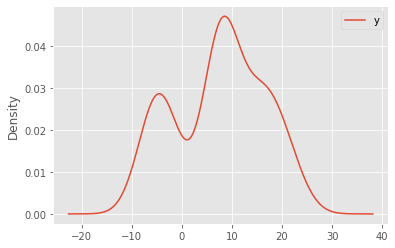

In [10]:
data.plot(kind='kde')

In [11]:
dataset = make_dataset_from_df(data, target_names=['y'], format_features_as='dict')
dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.float32, tf.float32)>

## 2. Define Model

In [12]:
# assumed number of underlying gaussian distributions
max_components = true_component_n

In [13]:
priors = OrderedDict(
    # prior for the weights of the individual gaussians
    weights = tfd.Dirichlet(
        concentration=tf.ones(max_components)
    ),
    # priors for the locations i.e. means of the gaussian components
    loc = tfd.Normal(
        loc=tf.zeros([max_components]),
        scale=tf.ones([max_components])*10.0
    ),
    # priors for the scale i.e. stddev of the gaussian components
    scale = tfd.HalfNormal(
        scale=tf.ones([max_components])*10.0
    )
)

# likelihood defining the gaussian mixture model
def likelihood(weights, loc, scale):
    return tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=weights),
        components_distribution=tfd.Normal(
            loc=loc, 
            scale=scale
        )
    )


In [14]:
# construct model
model = Model(
    priors=priors,
    likelihood=likelihood,
)

## 3. Variational Inference

In [15]:
  def get_hamiltonian_flow_bijector(unconstrained_event_dims, num_flows):
    return tfb.Chain([
        HamiltonianFlow(
            event_dims=unconstrained_event_dims,
            symplectic_integrator=LeapfrogIntegrator(), 
            step_sizes=tf.Variable(0.1), 
            num_integration_steps=2,
            hidden_layers=[128, 128]
        ) for _ in range(num_flows)
    ])

In [16]:
step_size = tf.Variable(0.1)
scale_fn = make_scale_fn(model.flat_unconstrained_param_event_ndims, hidden_layers=[128,128])
shift_fn = make_shift_fn(model.flat_unconstrained_param_event_ndims, hidden_layers=[128,128])

posterior_lift = lambda q: tfd.MultivariateNormalDiag(loc=shift_fn(q), scale_diag=scale_fn(q))

loc = tf.Variable(tf.zeros(model.flat_unconstrained_param_event_ndims*2))
scale = tf.Variable(tf.ones(model.flat_unconstrained_param_event_ndims*2)*0.1)

In [17]:
hnf = NormalizingFlow(
    model, 
    flow_bijector=get_hamiltonian_flow_bijector(model.flat_unconstrained_param_event_ndims, 2),
    posterior_lift_distribution=posterior_lift,
    base_distribution=tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale),
    extra_ndims=model.flat_unconstrained_param_event_ndims,
)

### VI fit

In [18]:
vi = VI(model, dataset, surrogate_posterior=hnf, 
        discrepancy_fn=tfp.vi.kl_reverse)

In [19]:
NUM_STEPS = 1000
SAMPLE_SIZE = 10
LEARNING_RATE = 1e-2

In [20]:
optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [21]:
approx_posterior, losses = vi.fit(optimizer=optimizer, num_steps=NUM_STEPS, sample_size=SAMPLE_SIZE)

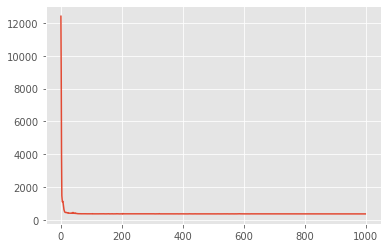

In [22]:
plt.plot(losses)

In [23]:
posterior_samples = approx_posterior.sample(1000)

In [24]:
posterior_samples = OrderedDict([(k, tf.expand_dims(v, axis=1)) for k,v in posterior_samples.items()])

#### Visualize Results

In [25]:
func_dict = {
    "mean": np.mean,
    "stddev": np.std,
    "hdi_3%": lambda x: np.percentile(x, 3),
    "mode": lambda x: np.percentile(x, 50),
    "hdi_97%": lambda x: np.percentile(x, 97),
}

In [26]:
az.summary(
    posterior_samples,
    stat_funcs=func_dict,
    extend=False
)

arviz - WARNING - Shape validation failed: input_shape: (1000, 1), minimum_shape: (chains=1, draws=4)


,mean,stddev,hdi_3%,mode,hdi_97%
weights[0],0.678,0.057,0.556,0.686,0.771
weights[1],0.043,0.047,0.005,0.028,0.170
weights[2],0.279,0.042,0.198,0.279,0.362
loc[0],11.778,0.680,10.516,11.786,13.016
loc[1],-1.921,3.338,-8.255,-1.937,4.359
loc[2],-4.704,0.374,-5.431,-4.689,-4.001
scale[0],5.557,0.501,4.630,5.563,6.475
scale[1],4.148,2.399,0.299,3.830,9.124
scale[2],1.924,0.283,1.411,1.921,2.466


In [27]:
true_component_weights, true_locs, true_scales

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.32, 0.22, 0.46], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([17., -5.,  8.], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 2., 1.], dtype=float32)>)